# Random Forest 

Basado en el ejemplo de Random Forest de <a href="https://www.datacamp.com/tutorial/random-forests-classifier-python#rdl">Datacamp</a> 

In [1]:
import pandas as pd
import numpy as np

# Modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


# Visualización
from sklearn.tree import export_graphviz
from IPython.display import Image
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns

In [2]:
bank_data=pd.read_csv("bank-additional-full.csv",delimiter=';')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
#preprocesamos datos
bank_data['default'] = bank_data['default'].map({'no':0,'yes':1,'unknown':0})
bank_data['y'] = bank_data['y'].map({'no':0,'yes':1})
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,0,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,0,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,0,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,0,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,0,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [4]:
# Separamos las características de la variable objetivo
X = bank_data.drop('y', axis=1)  
y = bank_data['y']

Llegados a este punto deberíamos utilizar solo características numéricas, en este caso si solo queremos age,default,cons.price.idx, cons.conf.idx entonces debemos utilizar solo esas, pero podríamos perder información que fuera relevante para predecir la variable objetivo.

Esto podríamos conseguirlo utilizando por ejemplo: <code>X_numeric = X.select_dtypes(include=['number'])</code>

Si no henos de convertir las variables categóricas a numéricas: con OneHotEnconder o con LabelEncoder, aquí os dejo un ejemplo con OneHotEncoder y un Pipeline

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Dividimos los datos en entrenamiento y prueba antes de preprocesarlos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificamos las columnas categóricas
categorical_columns = ['job', 'marital', 'education','housing', 'loan', 
                       'contact', 'month', 'day_of_week', 'poutcome']

# Creamos el preprocesador que convierte las columnas categóricas usando OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        #handle_unknown='ignore' interesante si trabajas con datos en vivo y en los que pueden aparecer categorías inesperadas
    ],
    remainder='passthrough',  # Las demás columnas (numéricas) se dejan como están
    force_int_remainder_cols=False  # las columnas que no se transforman siguen con su tipo de dato original
)
# Definir el pipeline para preprocesar los datos y definir el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Entrenar el pipeline con los datos de entrenamiento
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact', 'month',
                                                   'day_of_week',
                                                   'poutcome'])])),
                ('classifier', RandomForestClassifier())])

Ahora que está entrenado vamos a predecir en el conjunto de prueba

In [6]:
#predicciones
y_pred = pipeline.predict(X_test)

In [7]:
#evaluamos la precisión
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9124787569798495


### Ahora vamos a visualizar los primeros árboles de un RandomForestClassifier

#### 1. Vamos a extraer árboles individuales con estimators_

Como en nuestro caso estamos utilizando un pipeline no podemos acceder directamente porque el modelo está encapsulado en el pipeline. Pero podemos acceder a él de la siguiente forma:

In [8]:
rf_model = pipeline.named_steps['classifier']

Si ahora quisiésemos ver los árboles con el siguiente código nos daríamos cuenta que el número de características ha cambiado porque ahora tenemos más columnas al utilizar el OneHotEncoder, ya que se expanden en múltiples columnas, una por cada categoría. Así que previamente debemos obtener los nombres de las características transformadas.

In [9]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

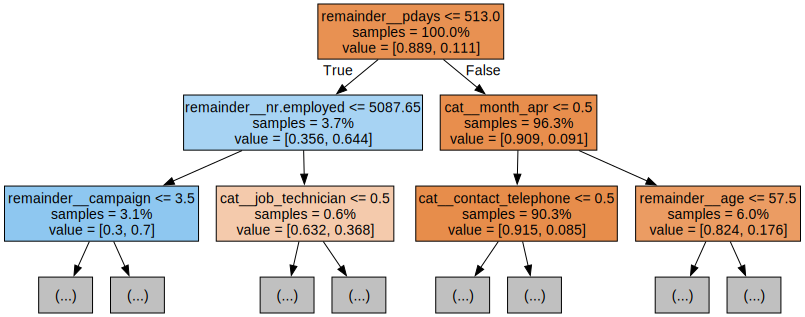

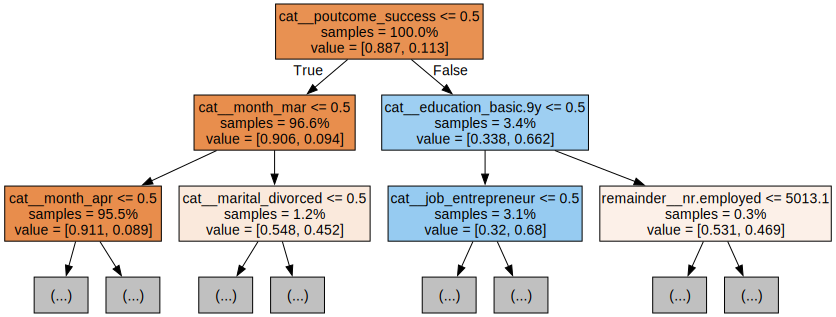

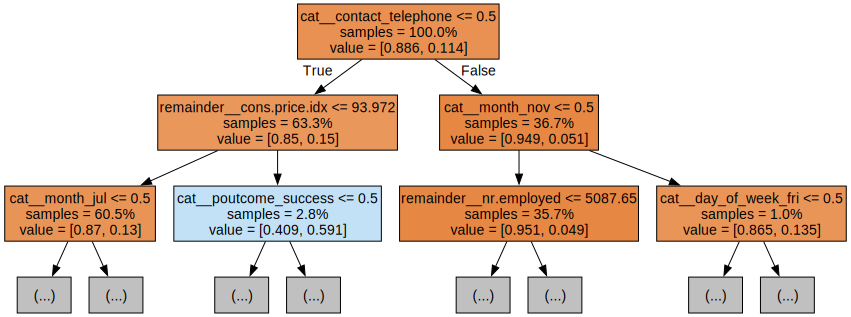

In [10]:
for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=feature_names,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

#### 2. Guardando los árboles

Igual que antes, teniendo en cuenta que el modelo está dentro de un pipeline

In [11]:
from sklearn.tree import plot_tree


# Extraer el modelo RandomForestClassifier del pipeline
rf_model = pipeline.named_steps['classifier']

# Obtener los nombres de las características transformadas
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()



Como puede ser muy grande vamos a restringir también la profundidad de los árboles

In [12]:
# Visualizar los primeros 3 árboles con profundidad limitada
for i in range(3):  # Iterar sobre los primeros 3 árboles
    # Exportar el árbol a formato DOT con max_depth limitado
    dot_data = export_graphviz(
        rf_model.estimators_[i],  # Árbol individual
        feature_names=feature_names,  # Nombres de las características transformadas
        class_names=["No", "Yes"],  # Ajustar según las clases, en este caso es binario
        filled=True,  # Colorea los nodos para mayor claridad
        max_depth=3,  # Limita la profundidad del árbol (ajusta según lo que necesites)
        impurity=False,  # No mostrar la impureza de los nodos
        proportion=True  # Mostrar proporción de instancias en cada nodo
    )

    # Crear y mostrar el gráfico
    graph = graphviz.Source(dot_data)
    #graph.view()  # Esto genera y abre el archivo visual del árbol
    # Guardar el gráfico como archivo PDF 
    output_filename = f"tree_{i}_depth"  # Nombre de archivo dinámico
    graph.render(output_filename, view=False,cleanup=True)  # Guardar y abrir el archivo
    print(f"Árbol {i} guardado como {output_filename}")

Árbol 0 guardado como tree_0_depth
Árbol 1 guardado como tree_1_depth
Árbol 2 guardado como tree_2_depth


## Ajuste de hiperparámetros

Vamos a utilizar *RandomizedSearchCV* de sklearn para encontrar la mejor combinación de hiperparámetros para un modelo, sin necesidad de probar todas las combinaciones posibles. Recordamos que selecciona aleatoriamente un número limitado de combinaciones de un conjunto de hiperparámetros definidos y evalúa su rendimiento.

De nuevo, como en nuestro caso estamos usando un pipeline, usamos __ para acceder a los parámetros de un paso intermedio dentro del pipeline, no accedemos directamente al modelo final.
Recordamos nuestro pipeline:

<code>
    pipeline = Pipeline(steps=[

        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]

</code>
como queremos acceder al número de estimadores del clasificador, ponemos el nombre y __

In [13]:
# Definir el espacio de búsqueda para los  hiperparámetros  Esta versión puede ralentizarse mucho...
param_dist = {
    'classifier__n_estimators': randint(10, 60),    # Número de árboles en RandomForest
    'classifier__max_depth': randint(1, 20),          # Profundidad máxima de los árboles
    'classifier__min_samples_split': randint(2, 20),  # Mínimas muestras para dividir un nodo
    'classifier__min_samples_leaf': randint(1, 20),   # Mínimas muestras en una hoja
    'classifier__bootstrap': [True, False]            # Usar muestreo bootstrap o no
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

# Mejor modelo
best_rf = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=15, classifier__min_samples_leaf=11, classifier__min_samples_split=9, classifier__n_estimators=30; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=15, classifier__min_samples_leaf=11, classifier__min_samples_split=9, classifier__n_estimators=30; total time=   0.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=15, classifier__min_samples_leaf=11, classifier__min_samples_split=9, classifier__n_estimators=30; total time=   0.4s
[CV] END classifier__bootstrap=True, classifier__max_depth=19, classifier__min_samples_leaf=11, classifier__min_samples_split=12, classifier__n_estimators=33; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__max_depth=19, classifier__min_samples_leaf=11, classifier__min_samples_split=12, classifier__n_estimators=33; total time=   0.5s
[CV] END classifier__bootstrap=True, classifier__m

### Matriz de confusión

Ya que estamos en un modelo de clasificación también podemos utilizar la matriz de confusión para evaluar el rendimiento del modelo. Vamos a ver cómo se clasifican las predicciones del modelo en comparación con los valores reales de las etiquetas del conjunto de datos, así podemos ver cómo es de preciso el modelo y ver errores.

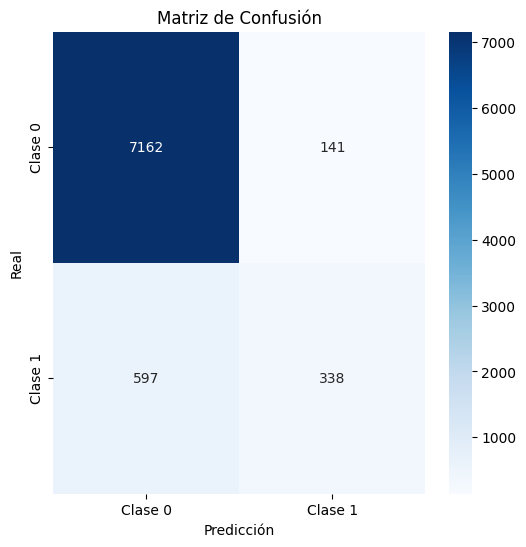

In [14]:

y_pred=best_rf.predict(X_test) #realizamos predicciones sobre el conjunto de prueba
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz de confusión usando un mapa de calor
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

También el resto de medidas:

In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9104151493080845
Precision: 0.7056367432150313
Recall: 0.36149732620320857


Como utilizamos un pipeline debemos acceder al modelo RandomForest dentro del pipeline para poder visualizar la importancia de las características

In [16]:
# Extraemos el modelo del pipeline
best_rf = pipeline.named_steps['classifier']

# Obtenemos las importancias de las características del modelo RandomForest
importances = best_rf.feature_importances_

# Obtener las características transformadas usando get_feature_names_out
# para las columnas categóricas
cat_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_columns)

cat_columns.size

50

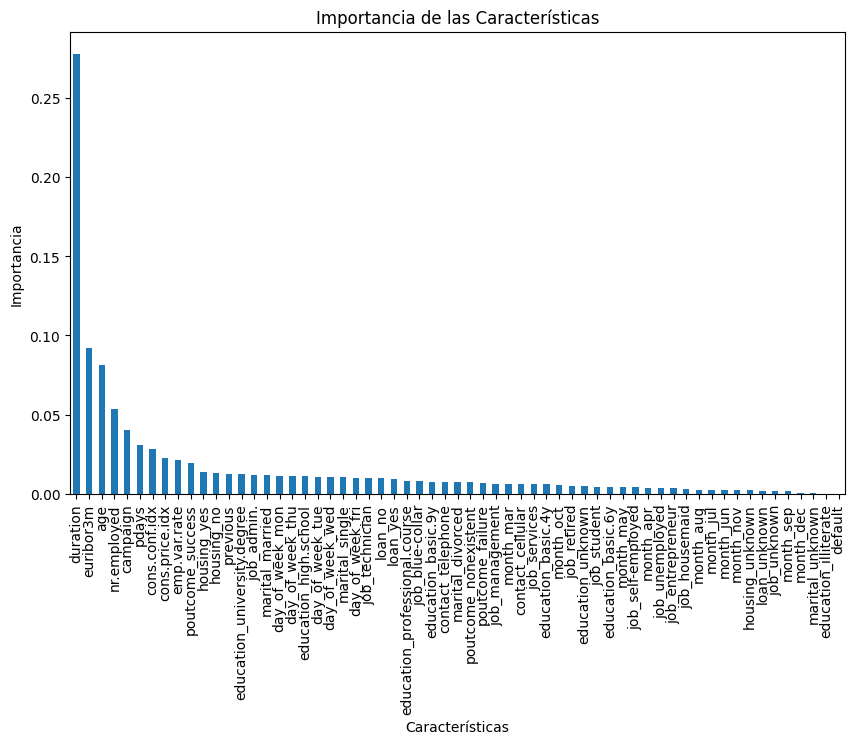

In [18]:
# Seleccionamos las columnas numéricas (sin transformación)
num_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Unimos las columnas transformadas y las no transformadas
feature_names = list(cat_columns) + list(num_columns)

# Creamos un DataFrame para las importancias con los nombres de las características
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Graficamos las importancias de las características
plt.figure(figsize=(10, 6))
feature_importances.plot.bar()
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las Características')
plt.show()

Fíjate que muchas de estas características podrían no tenerse en cuenta, este ejemplo está pensado para que veas el manejo de las características partiendo de los datos del pipeline...